%matplotlib widget# Using observatory data as Remote Reference

This is an example notebook for processing broadband data with an observatory as a remote reference. 

In [1]:
%matplotlib widget

## Download Geomagnetic Observatory Data

Download data from the USGS Geomagnetic data center for the full time of the survey.  First make a request dataframe.

In [1]:
import pandas as pd

from mth5.clients import MakeMTH5

2023-04-14 15:31:38,243 [line 135] mth5.setup_logger - INFO: Logging file can be found C:\Users\jpeacock\OneDrive - DOI\Documents\GitHub\mth5\logs\mth5_debug.log


In [2]:
request_df = pd.DataFrame(
    {
        "observatory": ["frn"],
        "type": ["adjusted"],
        "elements": [["x", "y"]],
        "sampling_period": [1],
        "start": ["2021-04-05T00:00:00"],
        "end": ["2021-04-16T00:00:00"],
    }
)

In [3]:
%%time
make_mth5_object = MakeMTH5(
    mth5_version="0.2.0",
    interact=False,
    save_path=r"c:\Users\jpeacock\OneDrive - DOI\MTData\GZ2021",
)
mth5_filename = make_mth5_object.from_usgs_geomag(request_df)

2023-04-14 14:54:48,256 [line 286] mth5.groups.base.MasterSurvey.add_survey - INFO: survey USGS-GEOMAG already exists, returning existing group.
2023-04-14 14:55:33,415 [line 678] mth5.timeseries.run_ts.RunTS.validate_metadata - WARNING: end time of dataset 2021-04-16T00:00:05+00:00 does not match metadata end 2021-04-16T00:00:00+00:00 updating metatdata value to 2021-04-16T00:00:05+00:00
2023-04-14 14:55:33,496 [line 313] mth5.groups.base.MasterStation.add_station - INFO: Station Fresno already exists, returning existing group.
2023-04-14 14:55:33,593 [line 761] mth5.groups.base.Station.add_run - INFO: run sp1_001 already exists, returning existing group.
2023-04-14 14:55:35,089 [line 755] mth5.mth5.MTH5.close_mth5 - INFO: Flushing and closing c:\Users\jpeacock\OneDrive - DOI\MTData\GZ2021\usgs_geomag_frn_xy.h5
2023-04-14 14:55:35,094 [line 325] mth5.mth5.MTH5.filename - WARNING: MTH5 file is not open or has not been created yet. Returning default name


Wall time: 46.9 s


## Combine Runs with sample rate of 1 second

Now we need to combine runs of various sample rates into a single run with the sample rate of 1 second.

read into channels, create a run, use reindex.

In [1]:
from matplotlib import pyplot as plt

from mth5 import read_file
from mth5.io.zen import Z3DCollection
from mth5.mth5 import MTH5

2023-04-21 10:58:35,048 [line 141] mth5.setup_logger - INFO: Logging file can be found C:\Users\jpeacock\OneDrive - DOI\Documents\GitHub\mth5\logs\mth5_debug.log


In [2]:
zc = Z3DCollection(r"c:\Users\jpeacock\OneDrive - DOI\MTData\GZ2021\gz316")
runs = zc.get_runs(sample_rates=[4096, 256])

In [3]:
runs["gz316"]["sr256_0003"]

,survey,station,run,start,end,channel_id,component,fn,sample_rate,file_size,n_samples,sequence_number,instrument_id,coil_number,calibration_fn
4,geysers01,gz316,sr256_0003,2021-04-10 01:09:58+00:00,2021-04-10 07:21:45.683594+00:00,1,hx,c:\Users\jpeacock\OneDrive - DOI\MTData\GZ2021...,256.0,22843068,5710767,3,ZEN_026,2304,None
5,geysers01,gz316,sr256_0003,2021-04-10 01:09:58+00:00,2021-04-10 07:21:45.683594+00:00,5,ey,c:\Users\jpeacock\OneDrive - DOI\MTData\GZ2021...,256.0,22839996,5710767,3,ZEN_026,316,None
6,geysers01,gz316,sr256_0003,2021-04-10 01:09:58+00:00,2021-04-10 07:21:45.683594+00:00,2,hy,c:\Users\jpeacock\OneDrive - DOI\MTData\GZ2021...,256.0,22842556,5710767,3,ZEN_026,2344,None
7,geysers01,gz316,sr256_0003,2021-04-10 01:09:58+00:00,2021-04-10 07:21:45.687500+00:00,4,ex,c:\Users\jpeacock\OneDrive - DOI\MTData\GZ2021...,256.0,22840000,5710768,3,ZEN_026,341,None


In [4]:
calibrate = False
m = MTH5()
if calibrate:
    m.data_level = 2
m.open_mth5(zc.file_path.joinpath("gz316_with_1s.h5"))

2023-04-21 10:58:52,235 [line 672] mth5.mth5.MTH5._initialize_file - INFO: Initialized MTH5 0.2.0 file c:\Users\jpeacock\OneDrive - DOI\MTData\GZ2021\gz316\gz316_with_1s.h5 in mode a


In [5]:
%%time
survey_group = m.add_survey("geysers01")
for station_id in runs.keys():
    station_group = survey_group.stations_group.add_station(station_id)
    station_group.metadata.update(zc.station_metadata_dict[station_id])
    station_group.write_metadata()
    run_list = []
    for run_id, run_df in runs[station_id].items():
        run_group = station_group.add_run(run_id)
        for row in run_df.itertuples():
            ch_ts = read_file(
                row.fn,
                calibration_fn=r"c:\Users\jpeacock\OneDrive - DOI\mt\antenna_20190411.cal",
            )
            # NOTE: this is where the calibration occurs
            if calibrate:
                ch_ts = ch_ts.remove_instrument_response()
            run_group.from_channel_ts(ch_ts)
        run_group.update_run_metadata()
        run_list.append(run_group.to_runts())

    combined_run = run_list[0].merge(run_list[1:], new_sample_rate=1)
    combined_run.run_metadata.id = "sr1_0001"
    combined_run_group = station_group.add_run("sr1_0001")
    combined_run_group.from_runts(combined_run)
    combined_run_group.update_run_metadata()

    station_group.update_station_metadata()

survey_group.update_survey_metadata()

2023-04-21 10:59:00,058 [line 358] mth5.timeseries.run_ts.RunTS._align_channels - INFO: Channels do not have a common end, using latest: 2021-04-10T01:09:43.998779296
2023-04-21 10:59:02,164 [line 678] mth5.timeseries.run_ts.RunTS.validate_metadata - WARNING: end time of dataset 2021-04-10T01:09:43.998535156+00:00 does not match metadata end 2021-04-10T01:09:43.998779296+00:00 updating metatdata value to 2021-04-10T01:09:43.998535156+00:00
2023-04-21 10:59:09,018 [line 358] mth5.timeseries.run_ts.RunTS._align_channels - INFO: Channels do not have a common end, using latest: 2021-04-10T06:59:43.996094000
2023-04-21 10:59:17,146 [line 358] mth5.timeseries.run_ts.RunTS._align_channels - INFO: Channels do not have a common end, using latest: 2021-04-10T07:09:43.998535156
2023-04-21 10:59:19,210 [line 678] mth5.timeseries.run_ts.RunTS.validate_metadata - WARNING: end time of dataset 2021-04-10T07:09:43.998291015+00:00 does not match metadata end 2021-04-10T07:09:43.998535156+00:00 updating 

Wall time: 1min 8s


In [7]:
m.close_mth5()

2023-04-21 11:00:01,318 [line 753] mth5.mth5.MTH5.close_mth5 - INFO: Flushing and closing c:\Users\jpeacock\OneDrive - DOI\MTData\GZ2021\gz316\gz316_with_1s.h5


In [8]:
combined_run

RunTS Summary:
	Survey:      geysers01
	Station:     gz316
	Run:         sr1_0001
	Start:       2021-04-09T23:24:59+00:00
	End:         2021-04-10T17:09:41+00:00
	Sample Rate: 1.0
	Components:  ['ex', 'ey', 'hx', 'hy']

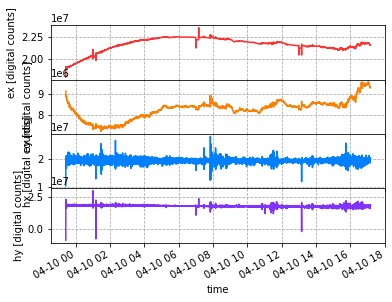

In [9]:
combined_run.plot()

In [10]:
c = combined_run.calibrate(bandpass={"low": 1e-4, "high": 0.45, "order": 1})

2023-04-21 11:00:04,015 [line 222] mt_metadata.base.metadata.frequency_response_table_filter.complex_response - WARNING: Extrapolating, use values outside calibration frequencies with caution
2023-04-21 11:00:04,439 [line 222] mt_metadata.base.metadata.frequency_response_table_filter.complex_response - WARNING: Extrapolating, use values outside calibration frequencies with caution


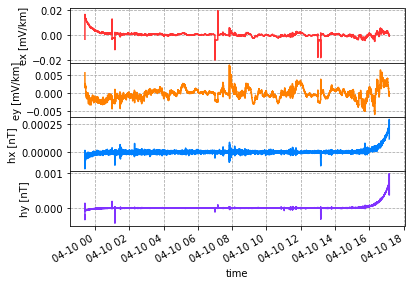

In [11]:
c.plot()

In [12]:
m_obs = MTH5()
m_obs.open_mth5(r"c:\Users\jpeacock\OneDrive - DOI\MTData\GZ2021\usgs_geomag_frn_xy.h5")

In [13]:
r_obs = m_obs.get_run("Fresno", "sp1_001", "USGS-GEOMAG")

In [14]:
r_obs_slice = r_obs.to_runts(start=combined_run.start, end=combined_run.end)

2023-04-21 11:00:05,862 [line 664] mth5.timeseries.run_ts.RunTS.validate_metadata - WARNING: start time of dataset 2021-04-09T23:24:59+00:00 does not match metadata start 2021-04-05T00:00:00+00:00 updating metatdata value to 2021-04-09T23:24:59+00:00
2023-04-21 11:00:05,869 [line 678] mth5.timeseries.run_ts.RunTS.validate_metadata - WARNING: end time of dataset 2021-04-10T17:09:41+00:00 does not match metadata end 2021-04-16T00:00:05+00:00 updating metatdata value to 2021-04-10T17:09:41+00:00


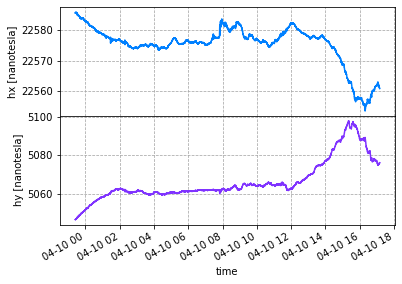

In [15]:
r_obs_slice.plot()

In [16]:
m_obs.close_mth5()

2023-04-21 11:00:06,382 [line 753] mth5.mth5.MTH5.close_mth5 - INFO: Flushing and closing c:\Users\jpeacock\OneDrive - DOI\MTData\GZ2021\usgs_geomag_frn_xy.h5


## Process With Aurora

In [1]:
# Required imports for the program.
import warnings
from pathlib import Path

from aurora.config.config_creator import ConfigCreator
from aurora.pipelines.process_mth5 import process_mth5
from aurora.pipelines.run_summary import RunSummary
from aurora.transfer_function.kernel_dataset import KernelDataset

warnings.filterwarnings("ignore")

No Logging configuration file found, using defaults.


2023-04-21 16:55:44,347 [line 141] mth5.setup_logger - INFO: Logging file can be found C:\Users\jpeacock\OneDrive - DOI\Documents\GitHub\mth5\logs\mth5_debug.log


In [2]:
station_path = Path(
    r"c:\Users\jpeacock\OneDrive - DOI\MTData\GZ2021\gz316\gz316_with_1s.h5"
)
obs_path = Path(r"c:\Users\jpeacock\OneDrive - DOI\MTData\GZ2021\usgs_geomag_frn_xy.h5")

In [3]:
mth5_run_summary = RunSummary()
mth5_run_summary.from_mth5s([station_path, obs_path])
run_summary = mth5_run_summary.clone()
run_summary.add_duration()
run_summary.df = run_summary.df[run_summary.df.sample_rate == 4096]
run_summary.mini_summary

2023-04-21 16:56:00,649 [line 753] mth5.mth5.MTH5.close_mth5 - INFO: Flushing and closing c:\Users\jpeacock\OneDrive - DOI\MTData\GZ2021\gz316\gz316_with_1s.h5
2023-04-21 16:56:00,754 [line 753] mth5.mth5.MTH5.close_mth5 - INFO: Flushing and closing c:\Users\jpeacock\OneDrive - DOI\MTData\GZ2021\usgs_geomag_frn_xy.h5


,survey,station_id,run_id,start,end
2,geysers01,gz316,sr4096_0002,2021-04-10 00:59:59+00:00,2021-04-10 01:09:43.997314453+00:00
4,geysers01,gz316,sr4096_0004,2021-04-10 06:59:59+00:00,2021-04-10 07:09:43.998535156+00:00
6,geysers01,gz316,sr4096_0006,2021-04-10 12:59:59+00:00,2021-04-10 13:09:43.997314453+00:00


In [4]:
kernel_dataset = KernelDataset()
kernel_dataset.from_run_summary(run_summary, "gz316")#, "Fresno")
mimimum_run_duration = 100  # seconds
kernel_dataset.drop_runs_shorter_than(mimimum_run_duration)
kernel_dataset.mini_summary

,survey,station_id,run_id,start,end,duration
0,geysers01,gz316,sr4096_0002,2021-04-10 00:59:59+00:00,2021-04-10 01:09:43.997314453+00:00,584.997314
1,geysers01,gz316,sr4096_0004,2021-04-10 06:59:59+00:00,2021-04-10 07:09:43.998535156+00:00,584.998535
2,geysers01,gz316,sr4096_0006,2021-04-10 12:59:59+00:00,2021-04-10 13:09:43.997314453+00:00,584.997314


In [5]:
cc = ConfigCreator()
config = cc.create_from_kernel_dataset(kernel_dataset)
for decimation in config.decimations:
    decimation.estimator.engine = "RME"
    decimation.window.type = "hamming"
    decimation.output_channels = ["ex", "ey"]

Bands not defined; setting to EMTF BANDS_DEFAULT_FILE
C:\Users\jpeacock\OneDrive - DOI\Documents\GitHub\aurora\aurora\config\emtf_band_setup\bs_test.cfg


In [6]:
%%time
tf_cls = process_mth5(
    config,
    kernel_dataset,
    units="MT",
    show_plot=False,
    z_file_path=None,
)
print("=== FINISHED ===")

2023-04-21T16:56:20 [line 242] aurora.pipelines.transfer_function_kernel.TransferFunctionKernel.memory_warning - INFO: Total memory: 15.88 GB
2023-04-21T16:56:20 [line 246] aurora.pipelines.transfer_function_kernel.TransferFunctionKernel.memory_warning - INFO: Total Bytes of Raw Data: 0.054 GB
2023-04-21T16:56:20 [line 251] aurora.pipelines.transfer_function_kernel.TransferFunctionKernel.memory_warning - INFO: Raw Data will use: 0.337 % of memory


2023-04-21 16:56:22,963 [line 678] mth5.timeseries.run_ts.RunTS.validate_metadata - WARNING: end time of dataset 2021-04-10T01:09:43.997070312+00:00 does not match metadata end 2021-04-10T01:09:43.998779296+00:00 updating metatdata value to 2021-04-10T01:09:43.997070312+00:00
2023-04-21 16:56:23,791 [line 2800] mth5.groups.master_station_run_channel.Magnetic.time_slice - WARNING: Requested slice is larger than data.  Slice length = 2396154, data length = (2396144,). Setting end_index to (2396144,)
2023-04-21 16:56:24,083 [line 2800] mth5.groups.master_station_run_channel.Magnetic.time_slice - WARNING: Requested slice is larger than data.  Slice length = 2396154, data length = (2396150,). Setting end_index to (2396150,)
2023-04-21 16:56:24,891 [line 358] mth5.timeseries.run_ts.RunTS._align_channels - INFO: Channels do not have a common end, using latest: 2021-04-10T07:09:43.998291015
2023-04-21 16:56:28,122 [line 678] mth5.timeseries.run_ts.RunTS.validate_metadata - WARNING: end time of

DATASET DF POPULATED


2023-04-21 16:56:34,782 [line 222] mt_metadata.base.metadata.frequency_response_table_filter.complex_response - WARNING: Extrapolating, use values outside calibration frequencies with caution
2023-04-21 16:56:34,899 [line 222] mt_metadata.base.metadata.frequency_response_table_filter.complex_response - WARNING: Extrapolating, use values outside calibration frequencies with caution
2023-04-21 16:56:39,785 [line 222] mt_metadata.base.metadata.frequency_response_table_filter.complex_response - WARNING: Extrapolating, use values outside calibration frequencies with caution
2023-04-21 16:56:39,947 [line 222] mt_metadata.base.metadata.frequency_response_table_filter.complex_response - WARNING: Extrapolating, use values outside calibration frequencies with caution
2023-04-21 16:56:44,598 [line 222] mt_metadata.base.metadata.frequency_response_table_filter.complex_response - WARNING: Extrapolating, use values outside calibration frequencies with caution
2023-04-21 16:56:44,702 [line 222] mt_me

2023-04-21T16:56:44 [line 133] aurora.transfer_function_helpers.get_band_for_tf_estimate - INFO: Processing band 0.006281s
2023-04-21T16:56:51 [line 133] aurora.transfer_function_helpers.get_band_for_tf_estimate - INFO: Processing band 0.004866s
2023-04-21T16:57:03 [line 133] aurora.transfer_function_helpers.get_band_for_tf_estimate - INFO: Processing band 0.003702s
2023-04-21T16:57:16 [line 133] aurora.transfer_function_helpers.get_band_for_tf_estimate - INFO: Processing band 0.002868s
2023-04-21T16:57:45 [line 133] aurora.transfer_function_helpers.get_band_for_tf_estimate - INFO: Processing band 0.002245s
2023-04-21T16:58:09 [line 133] aurora.transfer_function_helpers.get_band_for_tf_estimate - INFO: Processing band 0.001797s
2023-04-21T16:58:30 [line 133] aurora.transfer_function_helpers.get_band_for_tf_estimate - INFO: Processing band 0.001430s
2023-04-21T16:58:53 [line 133] aurora.transfer_function_helpers.get_band_for_tf_estimate - INFO: Processing band 0.001143s


2023-04-21 16:59:20,231 [line 237] aurora.pipelines.process_mth5.update_dataset_df - INFO: DECIMATION LEVEL 1
2023-04-21 16:59:23,316 [line 222] mt_metadata.base.metadata.frequency_response_table_filter.complex_response - WARNING: Extrapolating, use values outside calibration frequencies with caution
2023-04-21 16:59:23,425 [line 222] mt_metadata.base.metadata.frequency_response_table_filter.complex_response - WARNING: Extrapolating, use values outside calibration frequencies with caution


Could not detrend hx in time range 2021-04-10T06:59:59 to 2021-04-10T07:09:43.812500124. NO DATA
Could not detrend hy in time range 2021-04-10T06:59:59 to 2021-04-10T07:09:43.812500124. NO DATA
Could not detrend hx in time range 2021-04-10T06:59:59 to 2021-04-10T07:09:43.812500124. NO DATA
Could not detrend hy in time range 2021-04-10T06:59:59 to 2021-04-10T07:09:43.812500124. NO DATA


2023-04-21 16:59:24,753 [line 222] mt_metadata.base.metadata.frequency_response_table_filter.complex_response - WARNING: Extrapolating, use values outside calibration frequencies with caution
2023-04-21 16:59:24,857 [line 222] mt_metadata.base.metadata.frequency_response_table_filter.complex_response - WARNING: Extrapolating, use values outside calibration frequencies with caution
2023-04-21 16:59:26,277 [line 222] mt_metadata.base.metadata.frequency_response_table_filter.complex_response - WARNING: Extrapolating, use values outside calibration frequencies with caution
2023-04-21 16:59:26,410 [line 222] mt_metadata.base.metadata.frequency_response_table_filter.complex_response - WARNING: Extrapolating, use values outside calibration frequencies with caution


2023-04-21T16:59:26 [line 133] aurora.transfer_function_helpers.get_band_for_tf_estimate - INFO: Processing band 0.025126s


ValueError: indexes along dimension 'observation' are not equal

In [26]:
edi = tf_cls.write_tf_file(station_path.parent.joinpath("gz316_4096.edi"))

2023-04-21 11:01:13,464 [line 330] mt_metadata.base.metadata.define_measurement.write_measurement - INFO: No XMEAS information.
2023-04-21 11:01:13,464 [line 215] mt_metadata.transfer_functions.io.readwrite.write_file - INFO: Wrote c:\Users\jpeacock\OneDrive - DOI\MTData\GZ2021\gz316\gz316_1s_obs_rr.edi


## Use MTpy to plot

In [27]:
from mtpy import MT

2023-04-21 11:01:19,409 [line 113] matplotlib.get_mtpy_logger - INFO: Logging file can be found C:\Users\jpeacock\OneDrive - DOI\Documents\GitHub\mtpy\logs\matplotlib_warn.log


In [28]:
mt_obj = MT()
mt_obj.read_tf_file(edi.fn)

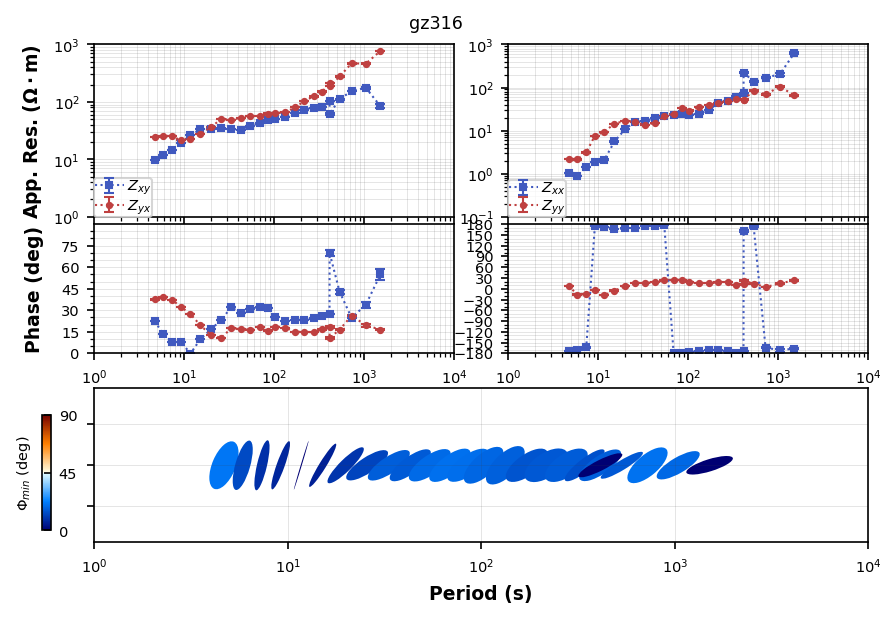

In [29]:
p1 = mt_obj.plot_mt_response(fig_num=5, plot_num=2)